## SOR Diffusion Limited Aggregation

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time

In [3]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects(N, omega,object_array,conc_mat):
    def SOR(conc_mat,omega):
        conc_mat[N-1] = 1
        
        # left boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][0] == 1:
                    conc_mat[k][0] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][0] = omega/4*(conc_mat[k+1][0] + conc_mat[k-1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]
        
        # middle of matrix
        for j in range(N-1):
            for i in range(1,N-1):
                # if part of object, concentration is zero
                if object_array[i][j] == 1:
                    conc_mat[i][j] = 0
                
                # otherwise: SOR equation
                else:
                    conc_mat[i][j] = (omega/4)*(conc_mat[i+1][j] + conc_mat[i-1][j] + conc_mat[i][j+1] + conc_mat[i][j-1]) + (1-omega)*conc_mat[i][j]
                    if conc_mat[i][j] < 0:
                        conc_mat[i][j] = 0
        # right boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][N-1] == 1:
                    conc_mat[k][N-1] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][N-1] = omega/4*(conc_mat[k+1][N-1] + conc_mat[k-1][N-1] + conc_mat[k][0] + conc_mat[k][N-2]) + (1-omega)*conc_mat[k][N-1]

        return conc_mat

    # initialise parameters
    i = 0 # iterations
    epsilon = 10**-5
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR(conc_mat,omega)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    return diff, i,conc_mat,conc_mat_old

In [5]:
# function to find the neighbours of a new object cell, add to set (so all candidates are unique) 
def get_candidates_SOR(object_loc,object_array,candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if object_loc[1]!=N-1 and object_array[object_loc[0]][object_loc[1]+1] == 0:
        candidates.add((object_loc[0],object_loc[1]+1))
    if object_loc[1]!=0 and object_array[object_loc[0]][object_loc[1]-1] == 0:
        candidates.add((object_loc[0],object_loc[1]-1))
    if object_loc[0]!=N-1 and object_array[object_loc[0]+1][object_loc[1]] == 0:
        candidates.add((object_loc[0]+1,object_loc[1]))
    if object_loc[0]!=0 and object_array[object_loc[0]-1][object_loc[1]] == 0:
        candidates.add((object_loc[0]-1,object_loc[1]))

    return candidates

# function to calculate the SOR of a grid with object, until convergence, with growing object
def SOR_DLA_to_solution(N,eta,omega,iterations):
    # calculate the analytic solution at t=1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1-x+2*i)/(2*np.sqrt(D*t))) - scipy.special.erfc((1+x+2*i)/(2*np.sqrt(D*t))) for i in range(10000)])
    x = np.arange(0,1,1/N)
    analytic_matrix = analytic_sol(x, 1, t)

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N,N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # source top boundary
    conc_mat[N-1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N,N))
    object_array[0][50] = 1
    candidates = set()
    candidates = get_candidates_SOR((0,50), object_array, candidates)
    
    # first SOR 
    difference, i, conc_mat,concold = SOR_with_objects(N,omega,object_array,conc_mat)
    
    def choose_growth(N,eta,conc_mat, candidates):

        # calculate the probabilities of growth for each candidate
        probs = []
        for i in candidates:
            prob = (conc_mat[i]**eta)/np.sum([conc_mat[cand]**eta for cand in candidates])
            probs.append(prob)

        # choose one and grow
        list_candidates = list(candidates)
        chosengrowth = list_candidates[np.random.choice(len(candidates),p=probs)]
        object_array[chosengrowth] = 1
        candidates = get_candidates_SOR(chosengrowth, object_array, candidates)
        conc_mat[chosengrowth] = 0
        
        return object_array,conc_mat, candidates
    
    # keep track of iterations needed
    totaliterations = 0
    
    # loop until object is grown 'iterations' times, finding SOR with each growth
    for k in range(iterations):
        object_array,conc_mat, candidates = choose_growth(N,eta,conc_mat, candidates)
        difference, i, conc_mat,concold = SOR_with_objects(N,omega,object_array,conc_mat)
        totaliterations += i

    plt.imshow(conc_mat,origin='lower',extent=[0,1,0,1],cmap='Spectral')
    return conc_mat,object_array, totaliterations
    


(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00835878, 0.00837162, 0.00837989, ..., 0.00829233, 0.00831914,
         0.00834117],
        [0.01672176, 0.01674733, 0.01676383, ..., 0.01658905, 0.01664257,
         0.01668654],
        ...,
        [0.97817423, 0.9781756 , 0.97817657, ..., 0.9781667 , 0.9781695 ,
         0.97817193],
        [0.9890871 , 0.98908771, 0.98908817, ..., 0.98908324, 0.98908464,
         0.98908588],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 7403)

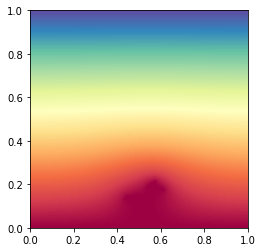

In [8]:
# test run

# initialise parameters
N = 100
eta = 1 
omega = 1.5
iterations = 100

SOR_DLA_to_solution(N,eta,omega,iterations)

In [ ]:
# run SOR method for DLA, for varying eta and omega values, saving the matrices and the total iterations for each run

# initialise parameters and lists
N = 100
eta_list = [1.5]
omega_list = [1.2,1.5]
#omega_list = np.arange(1.7, 2.0, 0.04)
iterations = 1000

# initialise iterations dataframe
eta_strings = [str(i) for i in eta_list]
omega_strings = [str(i) for i in omega_list]
df_ = pd.DataFrame(index=eta_strings, columns=omega_strings)
df_ = df_.fillna(0) 

# loop
for eta in eta_list:  
    for omega in omega_list:
        print(eta,omega)
        conc_mat, object_array,totalit = SOR_DLA_to_solution(N,eta,omega,iterations)
        np.save(f'concmatrices/conc_mat_{eta}_{omega}.npy',conc_mat)
        np.save(f'objectarrays/object_array_{eta}_{omega}.npy',object_array)
        df_[f'{omega}'][f'{eta}'] = totalit
        print(totalit)
        
#df_.to_excel('total_iterations.xlsx')

In [ ]:
plot_object_gradient(conc_mat, object_array,1.2)

In [ ]:
# function to make a combined imshow plot, where the object is visible along with the gradient

## code (with small adjustments) based on answer at: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
def plot_object_gradient(conc_mat, object_array,eta):
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N+3)
    cmap2._lut[:,-1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    img3 = plt.imshow(object_array, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0,1,0,1])

    plt.title(f"Object with gradient, eta = {eta}")
    plt.savefig(f'object_eta_{eta}.png',dpi=300)
    
    plt.show()

In [ ]:
# load in save files, plot diffusion gradient and object for differing eta values

conc_mat_00 = np.load('concmatrices/conc_mat_0_1.7.npy')
object_array_00 = np.load('objectarrays/object_array_0_1.7.npy')

conc_mat_03 = np.load('concmatrices/conc_mat_0.3_1.7.npy')
object_array_03 = np.load('objectarrays/object_array_0.3_1.7.npy')

conc_mat_06 = np.load('concmatrices/conc_mat_0.6_1.7.npy')
object_array_06 = np.load('objectarrays/object_array_0.6_1.7.npy')

conc_mat_09 = np.load('concmatrices/conc_mat_0.9_1.7.npy')
object_array_09 = np.load('objectarrays/object_array_0.9_1.7.npy')

conc_mat_12 = np.load('concmatrices/conc_mat_1.2_1.86.npy')
object_array_12 = np.load('objectarrays/object_array_1.2_1.86.npy')

conc_mat_15 = np.load('concmatrices/conc_mat_1.5_1.86.npy')
object_array_15 = np.load('objectarrays/object_array_1.5_1.86.npy')

plot_object_gradient(conc_mat_00, object_array_00, 0.0)
plot_object_gradient(conc_mat_03, object_array_03, 0.3)
plot_object_gradient(conc_mat_06, object_array_06, 0.6)
plot_object_gradient(conc_mat_09, object_array_09, 0.9)
plot_object_gradient(conc_mat_12, object_array_12, 1.2)
plot_object_gradient(conc_mat_15, object_array_15, 1.5)


In [ ]:
# 3d plot of total iterations and varying eta and omega values
total_iter_df = pd.read_excel('iterations_eta_malou_3.xlsx', engine='openpyxl')
eta_ls = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
total_iter_df_2 = total_iter_df.rename(columns = {'1.7': 1, '1.74': 2, '1.78': 3, '1.82': 4, '1.86': 5, '1.9000000000000001': 6, '1.9400000000000002': 7, '1.9800000000000002': 8},index={0: 0.0, 1: 0.3, 2: 0.6, 3: 0.9, 4: 1.2, 5: 1.5}).drop('Unnamed: 0', axis=1)

#total_iter_df_2.drop('Unnamed: 0', axis=1)
print(total_iter_df_2)
omega_list = np.arange(1.7,2.0,0.04)
#total_iter_df_2.columns = total_iter_df_2.columns.astype(int)

X,Y = np.meshgrid(omega_list,eta_ls)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_iter_df_2, cmap='viridis', edgecolor='none')
ax.view_init(30, 230)
ax.set_ylabel("Eta values")
ax.set_xlabel("Omega values")
ax.set_zlabel("Iterations to convergence")

plt.savefig("eta_om_iter.png",dpi=300)

## Adapted algorithm

In [ ]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects_fast(N, omega,object_array,conc_mat, change):
    def SOR_fast(conc_mat,omega, x, y):
        conc_mat[N-1] = 1
        
        # left boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][0] == 1:
                    conc_mat[k][0] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][0] = omega/4*(conc_mat[k+1][0] + conc_mat[k-1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]
        
        #make sure that you stay within the grid when updating
        if x < 2:
            x=2
        if y < 2:
            y=2
            
        # middle of matrix
        for j in range(x-1 ,N-1):
            for i in range(y-1,N-1):
                # if part of object, concentration is zero
                if object_array[i][j] == 1:
                    conc_mat[i][j] = 0
                
                # otherwise: SOR equation
                else:
                    conc_mat[i][j] = (omega/4)*(conc_mat[i+1][j] + conc_mat[i-1][j] + conc_mat[i][j+1] + conc_mat[i][j-1]) + (1-omega)*conc_mat[i][j]
                    if conc_mat[i][j] < 0:
                        conc_mat[i][j] = 0
        # right boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][N-1] == 1:
                    conc_mat[k][N-1] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][N-1] = omega/4*(conc_mat[k+1][N-1] + conc_mat[k-1][N-1] + conc_mat[k][0] + conc_mat[k][N-2]) + (1-omega)*conc_mat[k][N-1]

        return conc_mat

    # initialise parameters
    i = 0 # iterations
    epsilon = 10**-5
    diff = 100000 # set to large value    
    
    y, x= change
    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR_fast(conc_mat,omega, x, y)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        #increase the boundries for updating the grid
        y, x = change
        y -= 1
        x -= 1
        i += 1
    return diff, i,conc_mat,conc_mat_old

In [ ]:
# function to find the neighbours of a new object cell, add to set (so all candidates are unique) 
def get_candidates_SOR(object_loc,object_array,candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if object_loc[1]!=N-1 and object_array[object_loc[0]][object_loc[1]+1] == 0:
        candidates.add((object_loc[0],object_loc[1]+1))
    if object_loc[1]!=0 and object_array[object_loc[0]][object_loc[1]-1] == 0:
        candidates.add((object_loc[0],object_loc[1]-1))
    if object_loc[0]!=N-1 and object_array[object_loc[0]+1][object_loc[1]] == 0:
        candidates.add((object_loc[0]+1,object_loc[1]))
    if object_loc[0]!=0 and object_array[object_loc[0]-1][object_loc[1]] == 0:
        candidates.add((object_loc[0]-1,object_loc[1]))

    return candidates

# function to calculate the SOR of a grid with object, until convergence, with growing object
def SOR_DLA_to_solution_fast(N,eta,omega,iterations):
    # calculate the analytic solution at t=1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1-x+2*i)/(2*np.sqrt(D*t))) - scipy.special.erfc((1+x+2*i)/(2*np.sqrt(D*t))) for i in range(10000)])
    x = np.arange(0,1,1/N)
    analytic_matrix = analytic_sol(x, 1, t)

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N,N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # source top boundary
    conc_mat[N-1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N,N))
    object_array[0][int(N/2)] = 1
    candidates = set()
    candidates = get_candidates_SOR((0,int(N/2)), object_array, candidates)
    
    # first SOR 
    difference, i, conc_mat,concold = SOR_with_objects_fast(N,omega,object_array,conc_mat, np.array([0,50]))
    
    def choose_growth(N,eta,conc_mat, candidates):

        # calculate the probabilities of growth for each candidate
        probs = []
        for i in candidates:
            prob = (conc_mat[i]**eta)/np.sum([conc_mat[cand]**eta for cand in candidates])
            probs.append(prob)

        # choose one and grow
        list_candidates = list(candidates)
        chosengrowth = list_candidates[np.random.choice(len(candidates),p=probs)]
        object_array[chosengrowth] = 1
        candidates = get_candidates_SOR(chosengrowth, object_array, candidates)
        conc_mat[chosengrowth] = 0
        
        return object_array,conc_mat, candidates, chosengrowth
    
    # keep track of iterations needed
    totaliterations = 0
    
    # loop until object is grown 'iterations' times, finding SOR with each growth
    for k in range(iterations):
        object_array,conc_mat, candidates, chosengrowth = choose_growth(N,eta,conc_mat, candidates)
        difference, i, conc_mat,concold = SOR_with_objects_fast(N,omega,object_array,conc_mat, list(chosengrowth))
        totaliterations += i

    #plt.imshow(conc_mat,origin='lower',extent=[0,1,0,1],cmap='Spectral')
    plot_object_gradient(conc_mat, object_array, 1)
    return conc_mat,object_array, totaliterations
    

## Random walker

In [ ]:
# function to find growth candidates around object point
def get_candidates(cur_pos,object_array,candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if cur_pos[1]!=N-1 and object_array[cur_pos[0]][cur_pos[1]+1] == 0:
        candidates.add((cur_pos[0],cur_pos[1]+1))
    if cur_pos[1]!=0 and object_array[cur_pos[0]][cur_pos[1]-1] == 0:
        candidates.add((cur_pos[0],cur_pos[1]-1))
    if cur_pos[0]!=N-1 and object_array[cur_pos[0]+1][cur_pos[1]] == 0:
        candidates.add((cur_pos[0]+1,cur_pos[1]))
    if cur_pos[0]!=0 and object_array[cur_pos[0]-1][cur_pos[1]] == 0:
        candidates.add((cur_pos[0]-1,cur_pos[1]))
    
    return candidates

# random walker
def random_walker_DLA(N, object_array, candidates):
    # four surrounding coordinate changes: [-1,0], [1,0], [0,-1], [0,1]
    coordinate_changes = [(-1,0), (1,0), (0,-1), (0,1)]
    
    # initialise random walker, set growth to false
    growth = False
    cur_pos = (N-1,np.random.choice(np.arange(0,N-1,1)))
    
    # loop until object is grown 
    while growth == False:
        # generate coordinate at random point of top row 
        move_direction = np.random.choice(len(coordinate_changes))
        new_pos = tuple(np.add(cur_pos,coordinate_changes[move_direction]))
        
        # if new_pos != on grid:
        # periodic boundary
        if not 0 < new_pos[1] < N:
            if new_pos[1] == -1:
                new_pos = (new_pos[0],N-1)
            elif new_pos[1] == 100:
                new_pos = (new_pos[0],0)
        
        # if walker walks out top or bottom, reset at random top point
        if not 0 < new_pos[0] < N:
            new_pos = (N-1,np.random.choice(np.arange(0,N-1,1)))

        # move the walker
        cur_pos = new_pos
        
        # if new position is growth candidate and not yet in object, grow the object, update candidate list
        if object_array[cur_pos] != 1:
            if cur_pos in candidates:
                object_array[cur_pos] = 1
                growth = True
                candidates = get_candidates(cur_pos,object_array,candidates)
                candidates.remove(cur_pos)
 
    return object_array, candidates


In [ ]:
# initialise parameters, object array, and candidates
N = 100     
iterations = 700
object_array = np.zeros((N,N))
object_array[0][int(N/2)] = 1
candidates = set()
# get candidates around the seed of object
candidates = get_candidates((0,int(N/2)),object_array, candidates)

# grow the object x iterations
for _ in range(iterations):
    object_array, candidates = random_walker_DLA(N, object_array, candidates)

plt.imshow(object_array,origin='lower', extent=[0,1,0,1])
plt.title('Random walker growth')
plt.savefig('randomwalker.png')

In [ ]:
# random walker with sticking probability
def random_walker_DLA_stick(N, object_array, ps, candidates, total_iterations):
    
    # four random points: [-1,0], [1,0], [0,-1], [0,1]
    coordinate_changes = [(-1,0), (1,0), (0,-1), (0,1)]
    growth = False
    cur_pos = (N-1,np.random.choice(np.arange(0,N-1,1)))
    while growth == False:
        total_iterations += 1
        # generate coordinate at random point of top row 
        move_direction = np.random.choice(len(coordinate_changes))

        new_pos = tuple(np.add(cur_pos,coordinate_changes[move_direction]))
        # if new_pos != on grid:
        # periodic boundary
        if not 0 < new_pos[1] < N:
            if new_pos[1] == -1:
                new_pos = (new_pos[0],N-1)
            elif new_pos[1] == 100:
                new_pos = (new_pos[0],0)
        
        # if walker walks out top or bottom, reset at random top point
        if not 0 < new_pos[0] < N:
            new_pos = (N-1,np.random.choice(np.arange(0,N-1,1)))

        # if new position would be part of object, find another new position
        if object_array[new_pos] == 1:
            continue
            
        cur_pos = new_pos
        
        # if new position is growth candidate and not yet in object, grow the object, update candidate list

        if cur_pos in candidates and np.random.random() < ps:
            object_array[cur_pos] = 1
            growth = True
            candidates = get_candidates(cur_pos,object_array,candidates)
            candidates.remove(cur_pos)
                
    return object_array, candidates, total_iterations


In [ ]:
# initialise parameters, object array, and candidates
def random_walker_iterations(ps, N, iterations):

    object_array = np.zeros((N,N))
    object_array[0][50] = 1
    candidates = set()
    
    # get candidates around the seed of object
    candidates = get_candidates((0,50),object_array, candidates)
    total_it = 0

    for _ in range(700):
        object_array, candidates, total_it = random_walker_DLA_stick(N, object_array, ps, candidates, total_it)

    plt.imshow(object_array, origin='lower', extent=[0,1,0,1])
    plt.title(f'Random walker growth, Ps = {ps}')
    plt.savefig(f'randomwalker_{ps}.png')
    
    return total_it

ps_list = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
iterations_per_ps = []
for ps in ps_list:
    total_it = random_walker_iterations(ps, 100, 700)
    print(total_it)
    iterations_per_ps.append(total_it)

In [ ]:
plt.plot(ps_list,iterations_per_ps)
plt.xlabel('Ps')
plt.ylabel('Total iterations')
plt.title('Iterations needed for 700 growthsteps per Ps')
plt.savefig('it_random_walker_ps.png', dpi=300)

In [ ]:
# initialise parameters, object array, and candidates
ps = 1.0
N = 100     
iterations = 700
object_array = np.zeros((N,N))
object_array[0][50] = 1
candidates = set()
# get candidates around the seed of object
candidates = get_candidates((0,50),object_array, candidates)
total_iterations = 0

for _ in range(700):
    object_array, candidates, total_it = random_walker_DLA_stick(N, object_array, ps, candidates, total_iterations)

plt.imshow(object_array, origin='lower', extent=[0,1,0,1])
plt.title('Random walker growth, Ps = 0.7')
print(total_it)

## Gray-Scott

In [ ]:
# Time dependent diffusion equation

# initial parameters
N = 100
dt = 1
dx = 1
Du = 0.16
Dv = 0.08
f = 0.045
k = 0.06
totaltime = 500
current_time = 0

# initial matrix
conc_mat_u = np.zeros((N,N))
conc_mat_u[:] = 0.5

conc_mat_v = np.zeros((N, N))
conc_mat_v[45:55,45:55] = 0.25
#conc_mat_v[75:80,75:80] = 0.3

u_total = []
v_total = []

def Gray_Scott(conc_mat_u, conc_mat_v, current_time, stochastic=False):
    
    #initiate new matrices to fill with new concentration values
    new_conc_mat_u = np.zeros((N,N))
    new_conc_mat_v = np.zeros((N,N))
    
    #iterate over each coordinate except boundries
    for i in range(N-1):
        for j in range(N-1):
            #calculate the reaction rate and include some stochasticity, make sure negative reaction is not possible
            u = conc_mat_u[i][j]
            v = conc_mat_v[i][j]
            reaction = u*(v**2)
            if stochastic:
                reaction_stoch = abs(np.random.normal(reaction, reaction/10))
            else:
                reaction_stoch = reaction
            
            #calculate diffusion terms + influx u and outflux v
            diffusion_term_u = conc_mat_u[i,j] + ((dt*Du)/(dx**2))*(conc_mat_u[i+1][j] + conc_mat_u[i-1][j] + 
                                                                       conc_mat_u[i][j+1] + conc_mat_u[i][j-1] - 
                                                                       4*conc_mat_u[i][j]) + dt*f*(1-u)
            
            diffusion_term_v = conc_mat_v[i,j] + ((dt*Dv)/(dx**2))*(conc_mat_v[i+1][j] + conc_mat_v[i-1][j] + 
                                                                        conc_mat_v[i][j+1] + conc_mat_v[i][j-1] - 
                                                                        4*conc_mat_v[i][j]) - dt*(f+k)*v
            
            if diffusion_term_u < 0:
                diffusion_term_u = 0
            if diffusion_term_v < 0:
                diffusion_term_v = 0
                
            #save new concentrations
            new_conc_mat_u[i,j] = diffusion_term_u - dt*reaction_stoch
            new_conc_mat_v[i,j] = diffusion_term_v + dt*reaction_stoch
            
    # right and top boundaries for matrix u and v        
    for j in range(N-1):
        new_conc_mat_u[N-1][j] = conc_mat_u[N-1,j] + ((dt*Du)/(dx**2))*(conc_mat_u[0][j] + conc_mat_u[N-2][j] + conc_mat_u[N-1][j+1] + conc_mat_u[N-1][j-1] - 4*conc_mat_u[N-1][j]) - dt*conc_mat_u[N-1][j]*(conc_mat_v[N-1][j]**2) + dt*f*(1-conc_mat_u[N-1,j])
        new_conc_mat_u[j][N-1] = conc_mat_u[j,N-1] + ((dt*Du)/(dx**2))*(conc_mat_u[j+1][N-1] + conc_mat_u[j-1][N-1] + conc_mat_u[j][0] + conc_mat_u[j][N-2] - 4*conc_mat_u[j][N-1]) - dt*conc_mat_u[j][N-1]*(conc_mat_v[j][N-1]**2) + dt*f*(1-conc_mat_u[j,N-1])
        new_conc_mat_v[N-1][j] = conc_mat_v[N-1,j] + ((dt*Dv)/(dx**2))*(conc_mat_v[0][j] + conc_mat_v[N-2][j] + conc_mat_v[N-1][j+1] + conc_mat_v[N-1][j-1] - 4*conc_mat_v[N-1][j]) - dt*conc_mat_u[N-1][j]*(conc_mat_v[N-1][j]**2) - dt*(f+k)*conc_mat_v[N-1,j]
        new_conc_mat_v[j][N-1] = conc_mat_v[j,N-1] + ((dt*Dv)/(dx**2))*(conc_mat_v[j+1][N-1] + conc_mat_v[j-1][N-1] + conc_mat_v[j][0] + conc_mat_v[j][N-2] - 4*conc_mat_v[j][N-1]) - dt*conc_mat_u[j][N-1]*(conc_mat_v[j][N-1]**2) - dt*(f+k)*conc_mat_v[j,N-1]
    
    # top right corner for matrix u and v
    new_conc_mat_u[N-1][N-1] = conc_mat_u[N-1,N-1] + ((dt*Du)/(dx**2))*(conc_mat_u[0][N-1] + conc_mat_u[N-2][N-1] + conc_mat_u[N-1][0] + conc_mat_u[N-1][N-2] - 4*conc_mat_u[N-1][N-1]) - dt*conc_mat_u[N-1][N-1]*(conc_mat_v[N-1][N-1]**2) + dt*f*(1-conc_mat_u[N-1,N-1])
    new_conc_mat_v[N-1][N-1] = conc_mat_v[N-1,N-1] + ((dt*Dv)/(dx**2))*(conc_mat_v[0][N-1] + conc_mat_v[N-2][N-1] + conc_mat_v[N-1][0] + conc_mat_v[N-1][N-2] - 4*conc_mat_v[N-1][N-1]) - dt*conc_mat_u[N-1][N-1]*(conc_mat_v[N-1][N-1]**2) - dt*(f+k)*conc_mat_v[N-1,N-1]
    
    # increase time with dt
    current_time += dt
    
    return new_conc_mat_u, new_conc_mat_v, current_time

# loop until total time has been reached
while current_time < totaltime:
    conc_mat_u, conc_mat_v, current_time = Gray_Scott(conc_mat_u, conc_mat_v, current_time, stochastic=True)
    u_total.append(np.sum(conc_mat_u))
    v_total.append(np.sum(conc_mat_v))


# plots    
plt.imshow(conc_mat_u,origin='lower')
plt.colorbar()
plt.show()

plt.figure(dpi=300)
plt.title('Stochastic state Gray-Scott diffusion of V')
plt.imshow(conc_mat_v,origin='lower', vmin=0, vmax=0.4, extent=[0,1,0,1])
plt.colorbar()
plt.savefig('lowerleft2_045')
plt.show()

plt.figure()
plt.semilogy(u_total)
plt.semilogy(v_total)
plt.show()


In [ ]:
# initial parameters
N = 100
dt = 1
dx = 1
Du = 0.16
Dv = 0.08
f = 0.035
k = 0.06
totaltime = 7500
current_time = 0

# initial matrix
conc_mat_u = np.zeros((N,N))
conc_mat_u[:] = 0.5

conc_mat_v = np.zeros((N, N))
conc_mat_v[45:55,45:55] = 0.25

u_total = []
v_total = []

conc_mat_u, conc_mat_v, current_time = Gray_Scott(conc_mat_u, conc_mat_v, current_time)

snapshots = []
while current_time < totaltime:
    snapshots.append(conc_mat_v)
    conc_mat_u, conc_mat_v, current_time = Gray_Scott(conc_mat_u, conc_mat_v, current_time)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(dpi=300 ,figsize=(8,8))
plt.title('Gray-Scott diffusion')
a = snapshots[0]
im = plt.imshow(a, origin='lower',extent=[0,1,0,1], vmin=0, vmax=0.5)
bar = plt.colorbar(im)

def animate_func(i):
    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(fig,animate_func, frames = totaltime-1, interval=10, blit=True)

anim.save('diffusion_equation_pretty.mp4')

In [ ]:
plt.imshow(conc_mat_v,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
""" Finite Volume simulation """

# Simulation parameters
Nx                     = 400    # resolution x-dir
Ny                     = 100    # resolution y-dir
rho0                   = 100    # average density
tau                    = 0.6    # collision timescale
Nt                     = 4000   # number of timesteps
plotRealTime = True # switch on for plotting as the simulation goes along

# Lattice speeds / weights
NL = 9
idxs = np.arange(NL)
cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1

# Initial Conditions
F = np.ones((Ny,Nx,NL)) #* rho0 / NL
np.random.seed(42)
F += 0.01*np.random.randn(Ny,Nx,NL)
X, Y = np.meshgrid(range(Nx), range(Ny))
F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))
rho = np.sum(F,2)
for i in idxs:
    F[:,:,i] *= rho0 / rho

# Cylinder boundary
X, Y = np.meshgrid(range(Nx), range(Ny))
cylinder = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/4)**2

# Prep figure
fig = plt.figure(figsize=(4,2), dpi=80)

# Simulation Main Loop
for it in range(Nt):
        print(it)

        # Drift
        for i, cx, cy in zip(idxs, cxs, cys):
            F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
            F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)


        # Set reflective boundaries
        bndryF = F[cylinder,:]
        bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]


        # Calculate fluid variables
        rho = np.sum(F,2)
        ux  = np.sum(F*cxs,2) / rho
        uy  = np.sum(F*cys,2) / rho


        # Apply Collision
        Feq = np.zeros(F.shape)
        for i, cx, cy, w in zip(idxs, cxs, cys, weights):
            Feq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )

        F += -(1.0/tau) * (F - Feq)

        # Apply boundary 
        F[cylinder,:] = bndryF


        # plot in real time - color 1/2 particles blue, other half red
        if (plotRealTime and (it % 10) == 0) or (it == Nt-1):
            plt.cla()
            ux[cylinder] = 0
            uy[cylinder] = 0
            vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
            vorticity[cylinder] = np.nan
            cmap = plt.cm.bwr
            cmap.set_bad('black')
            plt.imshow(vorticity, cmap='bwr')
            plt.clim(-.1, .1)
            ax = plt.gca()
            ax.invert_yaxis()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')
            plt.pause(0.001)


    # Save figure
    plt.savefig('latticeboltzmann.png',dpi=240)
    plt.show()
        
    return 0